In [3]:
import pathlib
import numpy as np
from scipy import stats, signal, fft
from scipy.optimize import curve_fit
from scipy.ndimage import convolve
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from PIL import Image

## Data-Handling

In [45]:
# DATA_DIR = 'datasets_for_Statistician/Latent2048_19_Jul_2023_1'
DATA_DIR = 'data_map_cutouts/train_1000_2_npy/Primary_train/generated_data/'
BATCH_SIZE = 256
TOTAL_NO_IMAGES = 400

## Visualization

Shape of images from dataLoader: (128, 128)


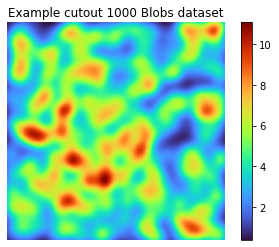

In [46]:

# Sampling from the dataset
image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
# plt.figure(figsize=(100,100))
# image_indx = 47
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

images = np.load(image_path)[0, :, :]
# images = cv2.GaussianBlur(images, (3,3), 0)


print("Shape of images from dataLoader:", images.shape)

# Displaying a sample input image
plt.imshow(images, cmap = 'turbo')
plt.axis('off')
plt.title('Example cutout 1000 Blobs dataset')
plt.colorbar()
plt.show()

## Plotting the Intensity distribution

(128, 128, 128)


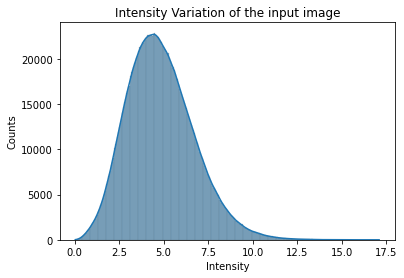

In [47]:
# image_indx = np.random.randint(0, TOTAL_NO_IMAGES)

image_path = DATA_DIR + '/' + str(0) + '.npy'
images = np.load(image_path)


for i in range(127):
    image_indx = i
    image_path = DATA_DIR + '/' + str(image_indx) + '.npy'
    temp_images = np.load(image_path)

    images = np.concatenate([images, temp_images], axis = 0)
print(images.shape)

# images = np.abs(images)

# images = images.detach().cpu().numpy()
images = np.reshape(images, (-1,))

# Use seaborn to plot the intensity distribution
sns.histplot(images, kde=True, binwidth=0.05)

# Set plot labels
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title("Intensity Variation of the input image")
# plt.xlim([0, 1.])
# Show the plot
plt.show()

## Plotting the marginal distributions

In [32]:
# Define the Gaussian function
def gaussian_with_mean(x, amplitude, mean, variance):
    return amplitude * np.exp(-(np.abs(x - mean) ** 2) / (2 * variance))

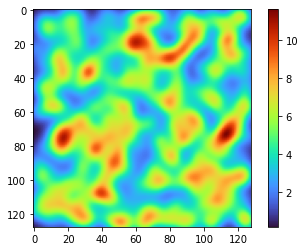

----Best-fit parameters---
Amplitude: 668.1580435552908
Mean: 88.64047108065868
Variance: 17116.549571086918


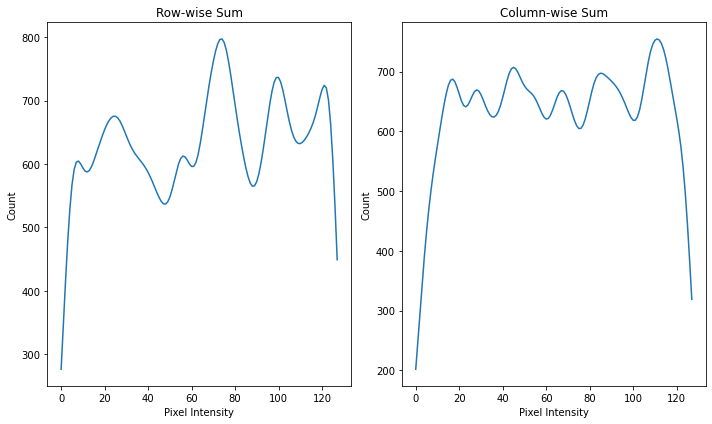

In [48]:
# image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

image = np.load(image_path)[0, :, :]
# images = cv2.GaussianBlur(images, (7,7), 0)


# Calculate the row-wise and column-wise histograms
row_hist = np.sum(image, axis=1)
col_hist = np.sum(image, axis=0)

plt.imshow(image, cmap='turbo')
plt.colorbar()
plt.show()

# Create subplots for row and column histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot row-wise histogram
axes[0].plot(row_hist)
x = np.arange(row_hist.size)
        # print(x, intensity_maps)

        # Fit the Gaussian curve to the data
initial_guess = [1, 0., 10]  # Initial parameter guesses for the fit
        # try:
optimized_parameters, _ = curve_fit(gaussian_with_mean, x, row_hist, p0=initial_guess, maxfev=1000000)

                # Extract the optimized parameter values
amplitude_opt, mean_opt, var_opt = optimized_parameters
print("----Best-fit parameters---")
print("Amplitude:", amplitude_opt)
print("Mean:", mean_opt)
print("Variance:", var_opt)

                # Generate the best-fit Gaussian curve using the optimized parameters
y_fit = gaussian_with_mean(x, amplitude_opt, mean_opt, var_opt)
                
# axes[0].plot(y_fit)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Count')
axes[0].set_title('Row-wise Sum')

# Plot column-wise histogram
axes[1].plot(col_hist)
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Count')
axes[1].set_title('Column-wise Sum')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Counting the average number of peaks per image

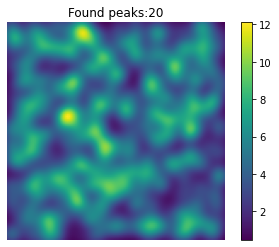

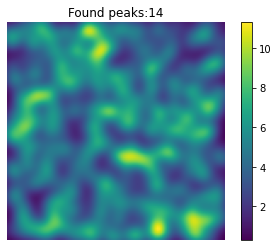

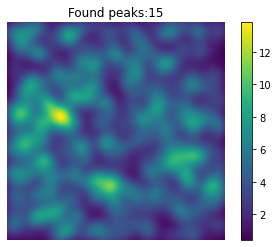

Found: 4108


In [49]:
from skimage.feature import peak_local_max
# images, _ = next(iter(dataLoader))
# images = images.detach().cpu().numpy()

peak_area_list = []
for i in range(BATCH_SIZE):

    # Need to remove the streaks

    image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
    image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

    image = np.load(image_path)[0, :, :]

    # grey = cv2.convertScaleAbs(image * 255)

    # _, binary = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # # Perform morphological operations to remove streaks
    # kernel = np.ones((7,7), np.uint8)
    # opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # # Invert the binary image to create a mask for the streaks
    # mask = 255 - opening
    # # Apply the mask to the original image
    # result = cv2.bitwise_and(grey, grey, mask=mask)

    
    
    # Define the minimum peak height and minimum distance between peaks
    min_peak_height = 0.
    min_peak_distance = 10

    # Find all the peaks in the image
    peaks = peak_local_max(image=image - np.min(image), 
                           min_distance=min_peak_distance, 
                           threshold_abs=min_peak_height)
    for peak in peaks:
        min_x = peak[0] - 10
        min_y = peak[1] - 10
        max_x = peak[0] + 11
        max_y = peak[1] + 11
        
        peak_area_list.append(image[min_x:max_x, min_y:max_y])

    if i % 100 == 0:
        # plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title("Found peaks:" + str(peaks.shape[0]))
        plt.axis('off')
        plt.colorbar()

        # plt.subplot(1,2,2)
        # plt.imshow(grey)
        # plt.axis('off')
        # plt.colorbar()
        plt.show()


print("Found:", len(peak_area_list))

In [50]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks

image = np.load(DATA_DIR + '/123.npy')[0, :, :]

_, median, sigma = sigma_clipped_stats(image, sigma=0.5)
threshold = median + (1.0 * sigma)
tbl = find_peaks(image, threshold, box_size=11)
# print(tbl['peak_value'])
daofind = IRAFStarFinder(fwhm=5.0, threshold=3*sigma)  
sources = daofind(image) 
print("Number of sources:", len(sources))
plt.imshow(image)
plt.show()
temp = np.zeros((21,21))
for x, y in sources['xcentroid', 'ycentroid']:
    x = int(x)
    y = int(y)
    min_x = max(0, x)
    min_y = max(0, y)
    max_x = min(128, x + 10)
    max_y = min(128, y + 10)

    print(x,y, min_x, max_x, min_y, max_y)
    # plt.imshow(image[min_x:max_x, min_y:max_y])
    # plt.show()
# sns.histplot(sources['flux'], kde=True, binwidth=0.5)


KeyboardInterrupt: 

41/50, 0.9037798507295082

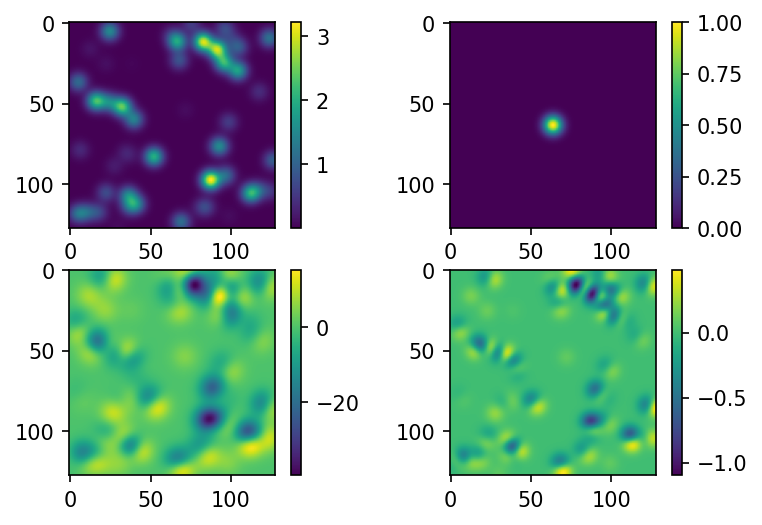

[[15, 89], [97, 88], [23, 96], [52, 31], [110, 38], [48, 17], [105, 113], [10, 80], [11, 66], [83, 52], [29, 103], [118, 8], [58, 39], [76, 92], [5, 24], [12, 100], [9, 123], [122, 69], [36, 5], [115, 40], [95, 97], [22, 68], [117, 17], [105, 120], [114, 83], [105, 23], [14, 105], [85, 124], [3, 95], [50, 22], [61, 98], [31, 108], [12, 83], [102, 88], [63, 41], [82, 34], [42, 117], [79, 6], [79, 96], [121, 3], [17, 93]]


In [ ]:
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)
X, Y = np.meshgrid(x, y)
a = np.vstack((X.ravel(), Y.ravel())).T
def make_blob(mean, var=1):
    return stats.multivariate_normal.pdf(a, mean=mean, cov=var * 1e-3).reshape((128, 128))

filter_gaussian = make_blob((0.5, 0.5))
filter_gaussian = filter_gaussian / np.max(filter_gaussian)
plt.figure(dpi=150)
plt.subplot(2,2,1)
plt.imshow(image)
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(filter_gaussian)
plt.colorbar()

image_temp = np.copy(image)

peak_pos = []
count = 0

while np.max(image_temp > 0.5) and count < 60:
    count += 1
    print(f'\r{count}/50, {np.max(image_temp)}', end='')
    result = convolve(image_temp, filter_gaussian, mode = 'constant', cval=0.)
    pos_max = np.argmax(result)
    x = pos_max // 128
    y = pos_max % 128
    peak_pos.append([x,y])
    a_max = result[x,y] / 52.26614518050251
    a_max = image_temp[x, y]

    to_remove = make_blob((y/128, x/128))
    to_remove = to_remove / np.max(to_remove)
    to_remove = to_remove * a_max

    image_temp = image_temp - to_remove

plt.subplot(2,2,3)
plt.imshow(result)
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(image_temp)
plt.colorbar()
plt.show()

print(peak_pos)

41
3 95
5 24
9 123
10 80
11 66
12 83
12 100
14 105
15 89
17 93
22 68
23 96
29 103
31 108
36 5
42 117
48 17
50 22
52 31
58 39
61 98
63 41
76 92
79 6
79 96
82 34
83 52
85 124
95 97
97 88
102 88
105 23
105 113
105 120
110 38
114 83
115 40
117 17
118 8
121 3
122 69


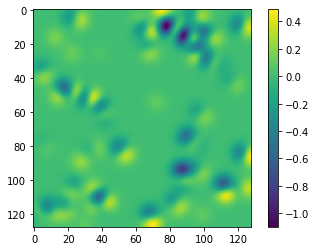

In [ ]:
plt.imshow(image_temp)
plt.colorbar()

peak_pos.sort()

print("No. of peaks found:", len(peak_pos))
for [x,y] in peak_pos:
    print(x,y)


In [108]:
temp = np.zeros((128,128))
temp = temp + make_blob((0.5,0.5))/156.7070567063135
# temp[64,64] = 1.3
# temp[32,32] = .5
temp_res = convolve(temp, filter_gaussian)
print(np.max(temp_res), np.max(temp), np.max(filter_gaussian))
del temp, temp_res

52.26614518050251 1.0 1.0


In [94]:
import cv2

abc = np.array([[1,0,0,1], 
                [0,0,0,0],
                [0,0,0,0],
                [0,0,0,0]])
ker = np.array([[1,1,1],
                [1,1,0], 
                [1,0,0]])
print(convolve(abc, ker, mode='constant', cval=0.))

[[1 0 1 1]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]]


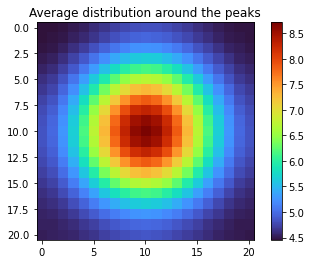

In [51]:
peak_avg = np.zeros((21, 21))
if len(peak_area_list) > 0: 
    for peak_area in peak_area_list:
        peak_avg += peak_area

    peak_avg = cv2.GaussianBlur(peak_avg, (3,3), 0)
    plt.imshow(peak_avg/len(peak_area_list), cmap='turbo')
else:
    plt.imshow(peak_avg)
plt.colorbar()
plt.title("Average distribution around the peaks")
plt.show()

In [52]:
# Define the Gaussian function
def gaussian(x, amplitude, variance):
    return amplitude * np.exp(-((x) ** 2) / (2 * variance))


In [53]:
def get_radial_dist(image = np.ones((21,21)), width=21, title='Intensity variation', best_fit=True):
    center = np.array([(width + 1) //2, (width + 1) // 2])
    # print("Center:", center)

    intensity_map = np.zeros(shape=(int(np.ceil(((width + 1 )// 2) * np.sqrt(2)))))
    counts = np.copy(intensity_map)

    for i in range(width):
        for j in range(width):
            pos = np.array([i, j])
            # print(pos)
            radius = int(np.linalg.norm(center - pos))
            # print(radius)
            intensity_map[radius] += image[i, j]
            counts[radius] += 1
    
    intensity_map = intensity_map / counts


    plt.plot(intensity_map)
    
    if best_fit:
        x = np.arange(intensity_map.size)
        # print(x, intensity_maps)

        # Fit the Gaussian curve to the data
        initial_guess = [1, 1.]  # Initial parameter guesses for the fit
        # try:
        optimized_parameters, _ = curve_fit(gaussian, x, intensity_map - np.min(intensity_map), p0=initial_guess, maxfev=1000000)

                # Extract the optimized parameter values
        amplitude_opt, var_opt = optimized_parameters
        print("----Best-fit parameters---")
        print("Amplitude:", amplitude_opt)
        # print("Mean:", mean_opt)
        print("Variance:", var_opt)

                # Generate the best-fit Gaussian curve using the optimized parameters
        y_fit = gaussian(x, amplitude_opt, var_opt) + np.min(intensity_map)
                
        plt.plot(y_fit)
        # except:
        #     print("ERROR: Best-fit Gaussian not found")
        # print(counts[0], counts[-1])
        plt.legend(['True intensity variation', 'Best-fit Gaussian'])
    plt.title(title)
    plt.show()

    return intensity_map

----Best-fit parameters---
Amplitude: 3.9961950637811534
Variance: 19.032367809667843


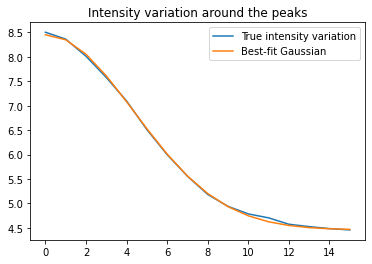

array([8.50348799, 8.36299043, 8.01214331, 7.5769738 , 7.09568547,
       6.51037112, 5.99752013, 5.55570217, 5.18264488, 4.93797437,
       4.78424882, 4.70297136, 4.57237945, 4.52352958, 4.4828119 ,
       4.4562518 ])

In [54]:
get_radial_dist(peak_avg / len(peak_area_list), title='Intensity variation around the peaks')

In [55]:
print("Average no. of peaks per image:", len(peak_area_list)/BATCH_SIZE)

Average no. of peaks per image: 16.046875


In [56]:
# Clean-up
del peak_area_list, peak_avg, peak, peak_area, peaks

## Image fft

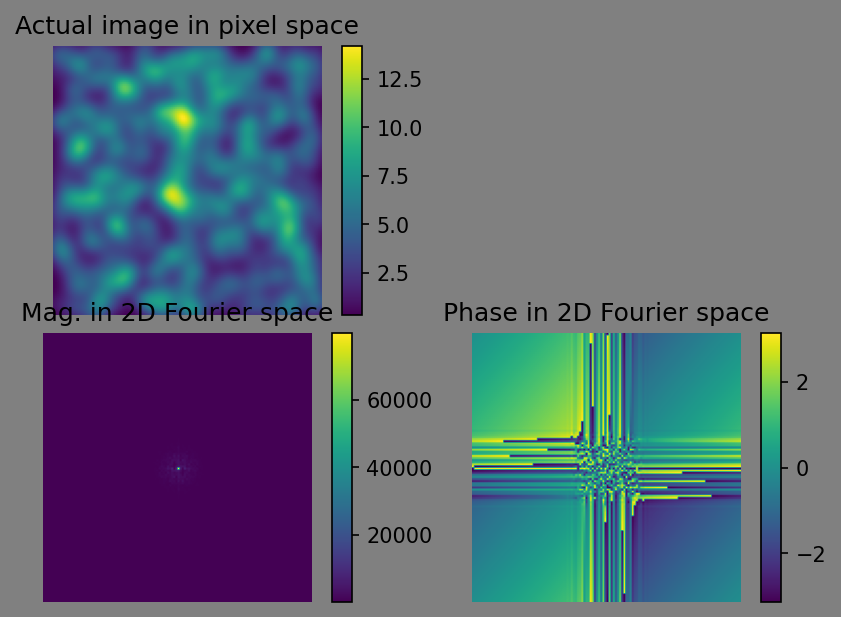

In [57]:
image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

image = np.load(image_path)[0, :, :]

# images = images - np.mean(images)

images_fft = fft.fftshift(fft.fft2(image))

images_fft_abs = np.abs(images_fft)

images_fft_abs[np.angle(images_fft) < -np.pi / 2] *= -1
images_fft_abs[np.angle(images_fft) > np.pi / 2] *= -1

plt.figure(constrained_layout = True, dpi=150, facecolor='0.5')

# images_fft_abs = np.sum(images_fft_abs, axis=0)
plt.subplot(2,2,1)
plt.imshow(image)
plt.colorbar()
plt.title("Actual image in pixel space")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow((np.abs(images_fft[ :, :])))
plt.colorbar()
plt.title("Mag. in 2D Fourier space")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(np.angle(images_fft[:, :]))
plt.colorbar()
plt.title("Phase in 2D Fourier space")
plt.axis('off')

plt.show()

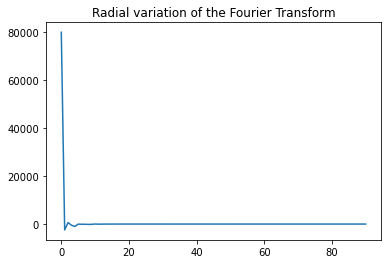

array([ 7.97787814e+04, -2.43802881e+03,  6.14732110e+02, -4.84941035e+02,
       -9.98804196e+02, -2.87559440e+01, -8.79166016e+01, -8.06566071e+01,
       -1.49533984e+02, -9.96597932e+01,  7.70345889e+00, -5.48904544e+01,
       -2.86074466e+01, -1.68542407e+01, -6.90423617e+00, -4.69541780e+00,
       -5.96849343e+00,  1.70256787e-01,  1.15732940e+00,  1.05049300e+00,
        1.51631151e+00,  1.63757221e+00,  1.46482374e+00,  1.41962632e+00,
        1.37584785e+00,  1.33825806e+00,  1.29482995e+00,  1.28374334e+00,
        1.11051629e+00,  1.44153010e+00,  4.47614691e-01,  4.75867337e-01,
        4.02301905e-01,  4.55986714e-01,  4.36794523e-01,  9.64462428e-01,
        8.70735589e-01,  8.84255108e-01,  7.90314864e-01,  8.09573071e-01,
        1.16583421e+00,  1.28315619e+00,  6.95858428e-01,  6.32562411e-01,
        6.78662189e-01,  3.63468519e-01,  4.89744923e-01,  5.33350668e-01,
        6.66811345e-01,  6.72623764e-01,  7.17865000e-01,  7.27684253e-01,
        1.21354319e+00,  

In [58]:
get_radial_dist(image = images_fft_abs[:, :], 
                width = 128, 
                best_fit = False, 
                title = 'Radial variation of the Fourier Transform')

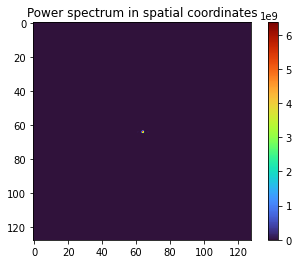

In [59]:
power_spectrum = np.abs(np.conj(images_fft) * images_fft)
plt.imshow((power_spectrum[:, :]), cmap='turbo')
plt.colorbar()
plt.title("Power spectrum in spatial coordinates")
plt.show()

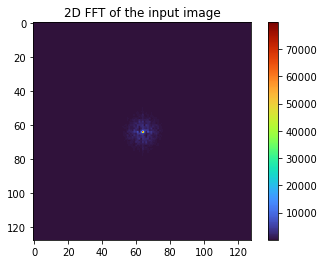

In [60]:
plt.imshow(np.abs(images_fft), cmap='turbo')
plt.title("2D FFT of the input image")
plt.colorbar()
plt.show()